In [78]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib.pylab as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
sys.path.append("/hetghome/antonpr/xmax_sigma/flincpy")
from cascade.cascade_driver import CascadeDriver, InteractionModel

In [80]:
import chromo
target = chromo.kinematics.CompositeTarget([("N", 0.78), ("O", 0.22)])
ekin = chromo.kinematics.FixedTarget(1e7, "O16", target)
model = chromo.models.DpmjetIII191
    
int_model0 = InteractionModel(model, ekin, target)

In [99]:
from mceq_utils.mceq_comparison import MceqWrapper
mceq_wrapper = MceqWrapper(pdg_id = 2212,
                           energy = 1e3,
                           theta_deg = 30,
                           slant_depths=[100, 200, 600, 1195],
                           energy_range=[1e-1, 1e3])

In [120]:
cas_driver = CascadeDriver(int_model0)

In [121]:
# mceq_decaying_pdgs = [-11, 11, -12, 12, -13, 13, -14, 14, 
#                       -16, 16, 22, -211, 211,
#                         111, 130, 310, -321, 321, 
#                         -411, 411, -421, 421, -431, 431, 
#                         -2112, 2112, -2212, 2212, -3122, 3122
#                         ]


cas_driver.simulation_parameters(pdg = mceq_wrapper.pdg_id, energy = mceq_wrapper.energy, 
                                 zenith_angle = mceq_wrapper.theta_deg, xdepth = 0,
                                 threshold_energy = mceq_wrapper.energy*0.1, stop_height = 0,
                                 accumulate_runs = True, reset_ids = True,
                                 decay_when_final_pdgs = mceq_wrapper.resonance_pdgs
                                #  decay_when_final_pdgs = [111, -211, 211, -3122, 3122]
                                 )


stop depth = 1195.9290875457918


In [122]:
cas_driver.run(1000)

  3%|▎         | 27/1000 [00:00<00:28, 34.62it/s]

100%|██████████| 1000/1000 [00:15<00:00, 63.96it/s]


In [123]:
from cascade.cascade_analysis import CascadeAnalysis
cascade_analysis = CascadeAnalysis(cas_driver)
cascade_analysis.print_stats()

Number of runs = 1000
Initial state:
  $p$(2212) with energy = 1.000e+03

Final state:
  Number of all particles in cascade = 114002
  Number of final particles = 87988
  Number of interactions = 3417
  Number of decays = 22597
  Max number of generations = 8

  Max xdepth = 1195.9290875457918
  Exectution time = 15.47 s
  Exectution time per run = 0.02 s
  Size of cascade_driver object = 25.24 Mb

Energy conservation in cascade:
  Initial energy = 1.00000e+03 GeV
  Energy in final particles = 1.00617e+03 GeV
  Relative gain(+)/loss(-) 6.167e-03
All final ids are unique, min = 4, max = 114001


{111: 17799, 211: 15730, -211: 15439, 2112: 4251, 2212: 4194, 22: 3882, 321: 1062, 310: 1016, 130: 1009, -321: 752, -2112: 594, 3122: 507, -2212: 470, -13: 322, 14: 322, 13: 245, -14: 245, -3122: 175, -11: 33, 11: 27, 12: 14, -12: 8}


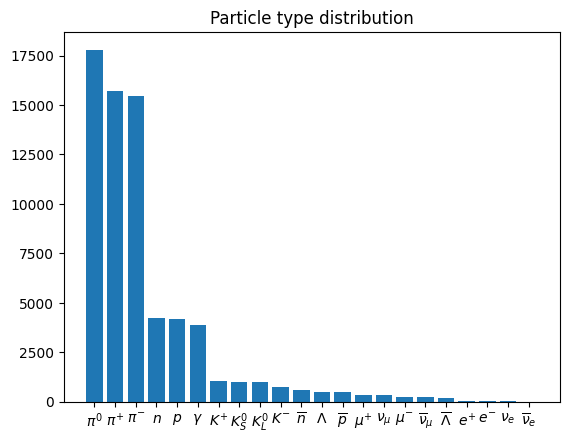

In [118]:
cascade_analysis.plot_ptypes_dist(from_ = 0)

In [124]:
mceq_wrapper.collector.clear()
mceq_wrapper.collector.add_particles(cas_driver.final_stack.valid())

In [125]:
len(cas_driver.final_stack.valid())

87988

In [126]:
np.sum(cas_driver.final_stack.valid().energy)

1006166.6202673608

In [127]:
mceq_wrapper.collector.tot_particles_on_grid()

85689.00000000003

In [128]:
mceq_wrapper.collector.tot_energy_on_grid()

1006058.987331763

In [52]:
from MCEq.core import MCEqRun
import mceq_config as config
import crflux.models as pm
# config.mceq_db_fname = "/hetghome/antonpr/MCEq/MCEq/data/mceq_db_lext_dpm191_v150.h5"

config.adv_set["exclude_from_mixing"] = [13, 111]
config.adv_set["disable_decays"] = [111]
config.e_min = 0.1
config.e_max = 2e3
config.hybrid_crossover = 0.5
mceq_run = MCEqRun(
            #provide the string of the interaction model
            interaction_model="DPMJET-III-19.1",
            #primary cosmic ray flux model
            primary_model = (pm.HillasGaisser2012, "H3a"),
            # Zenith angle in degrees. 0=vertical, 90=horizontal
            theta_deg=30,
            density_model = ("CORSIKA", ("USStd", None))
        )

MCEqRun::set_interaction_model(): DPMJETIII191


ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


In [72]:
from mceq_utils.mceq_comparison import MceqWrapper

In [76]:
mceq_wrapper = MceqWrapper(pdg_id = 2212,
                           energy = 1e2,
                           theta_deg = 30,
                           slant_depths=[100, 200, 600, 1195],
                           energy_range=[1e-1, 1e3])

In [71]:
from mceq_utils.grid_collector import MceqGridCollector
grid_collector = MceqGridCollector(mceq_wrapper)

In [ ]:
grid_collector.

In [56]:
mceq_wrapper.pdg_mceqidx_map

{-11: 1,
 11: 4,
 -12: 6,
 12: 7,
 -13: 9,
 13: 12,
 -14: 14,
 14: 15,
 -16: 16,
 16: 17,
 22: 18,
 130: 19,
 -211: 20,
 211: 21,
 -321: 22,
 321: 23,
 -2112: 24,
 2112: 25,
 -2212: 26,
 2212: 27}

In [47]:
mceq_wrapper.solve_single_particle([100, 300, 600])

In [48]:
mceq_wrapper.get_fluxes(pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("pi0", "pi0"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-")
                     ])

In [37]:
mceq_wrapper._particle_list()

In [51]:
mceq_wrapper.e_max

1000.0

In [30]:
mceq_wrapper.resonance_pdgs

[-3122, 3122, 310, -411, 411, -431, 431, -421, 421, 111]

In [17]:
len(mceq_wrapper.flux[0])

8

In [4]:
mceq_run.e_grid.shape

(64,)

In [5]:
mceq_run._phi0.shape[0]/mceq_run.e_grid.shape[0]

84.0

In [42]:
mceq_run.pman.pdg2mceqidx

{(-11, -1): 0,
 (-11, 0): 1,
 (-11, 1): 2,
 (11, -1): 3,
 (11, 0): 4,
 (11, 1): 5,
 (-12, 0): 6,
 (12, 0): 7,
 (-13, -1): 8,
 (-13, 0): 9,
 (-13, 1): 10,
 (13, -1): 11,
 (13, 0): 12,
 (13, 1): 13,
 (-14, 0): 14,
 (14, 0): 15,
 (-16, 0): 16,
 (16, 0): 17,
 (22, 0): 18,
 (130, 0): 19,
 (-211, 0): 20,
 (211, 0): 21,
 (-321, 0): 22,
 (321, 0): 23,
 (-2112, 0): 24,
 (2112, 0): 25,
 (-2212, 0): 26,
 (2212, 0): 27,
 (-3122, 0): -1,
 (3122, 0): -1,
 (310, 0): -1,
 (-411, 0): -1,
 (411, 0): -1,
 (-431, 0): -1,
 (431, 0): -1,
 (-421, 0): -1,
 (421, 0): -1,
 (111, 0): -1,
 (-1000012, 0): 28,
 (1000012, 0): 29,
 (-1000013, -1): 30,
 (-1000013, 1): 31,
 (1000013, -1): 32,
 (1000013, 1): 33,
 (-1000014, 0): 34,
 (1000014, 0): 35,
 (-1010012, 0): 36,
 (1010012, 0): 37,
 (-1010013, -1): 38,
 (-1000013, 0): 39,
 (-1010013, 1): 40,
 (1010013, -1): 41,
 (1000013, 0): 42,
 (1010013, 1): 43,
 (-1010014, 0): 44,
 (1010014, 0): 45,
 (-1020012, 0): 46,
 (1020012, 0): 47,
 (-1020014, 0): 48,
 (1020014, 0): 49,

In [21]:
for ipart in mceq_run.pman.all_particles:
    # print(type(ipart))
    print(ipart.pdg_id, ipart.name, ipart.mceqidx, f"{ipart.E_mix:.3e}")

(-11, -1) e+_l 0 0.000e+00
(-11, 0) e+ 1 0.000e+00
(-11, 1) e+_r 2 0.000e+00
(11, -1) e-_l 3 0.000e+00
(11, 0) e- 4 0.000e+00
(11, 1) e-_r 5 0.000e+00
(-12, 0) antinue 6 0.000e+00
(12, 0) nue 7 0.000e+00
(-13, -1) mu+_l 8 0.000e+00
(-13, 0) mu+ 9 0.000e+00
(-13, 1) mu+_r 10 0.000e+00
(13, -1) mu-_l 11 0.000e+00
(13, 0) mu- 12 0.000e+00
(13, 1) mu-_r 13 0.000e+00
(-14, 0) antinumu 14 0.000e+00
(14, 0) numu 15 0.000e+00
(-16, 0) antinutau 16 0.000e+00
(16, 0) nutau 17 0.000e+00
(22, 0) gamma 18 0.000e+00
(111, 0) pi0 19 0.000e+00
(130, 0) K_L0 20 2.239e+01
(-211, 0) pi- 21 7.079e+00
(211, 0) pi+ 22 8.913e+00
(-321, 0) K- 23 7.079e+01
(321, 0) K+ 24 8.913e+01
(-2112, 0) nbar0 25 1.122e-01
(2112, 0) n0 26 1.122e-01
(-2212, 0) pbar- 27 0.000e+00
(2212, 0) p+ 28 0.000e+00
(-3122, 0) Lambdabar0 -1 1.778e+03
(3122, 0) Lambda0 -1 1.778e+03
(310, 0) K_S0 -1 1.778e+03
(-411, 0) D- -1 1.778e+03
(411, 0) D+ -1 1.778e+03
(-431, 0) D_s- -1 1.778e+03
(431, 0) D_s+ -1 1.778e+03
(-421, 0) Dbar0 -1 1.778

In [53]:
sys.path.append("/hetghome/antonpr/xmax_sigma/flincpy")
from mceq_utils.grid_collector import MceqGridCollector
from mceq_utils.mceq_solve_rhs import solve_rhs
grid_collector = MceqGridCollector(mceq_run=mceq_run,
                                   int_grid = [600, 800, 900, 1000])

MCEq pdgs:
pdg_mceq = (-11, -1), mceq_idx = 0
pdg_mceq = (-11, 0), mceq_idx = 1
pdg_mceq = (-11, 1), mceq_idx = 2
pdg_mceq = (11, -1), mceq_idx = 3
pdg_mceq = (11, 0), mceq_idx = 4
pdg_mceq = (11, 1), mceq_idx = 5
pdg_mceq = (-12, 0), mceq_idx = 6
pdg_mceq = (12, 0), mceq_idx = 7
pdg_mceq = (-13, -1), mceq_idx = 8
pdg_mceq = (-13, 0), mceq_idx = 9
pdg_mceq = (-13, 1), mceq_idx = 10
pdg_mceq = (13, -1), mceq_idx = 11
pdg_mceq = (13, 0), mceq_idx = 12
pdg_mceq = (13, 1), mceq_idx = 13
pdg_mceq = (-14, 0), mceq_idx = 14
pdg_mceq = (14, 0), mceq_idx = 15
pdg_mceq = (-16, 0), mceq_idx = 16
pdg_mceq = (16, 0), mceq_idx = 17
pdg_mceq = (22, 0), mceq_idx = 18
pdg_mceq = (111, 0), mceq_idx = 19
pdg_mceq = (130, 0), mceq_idx = 20
pdg_mceq = (-211, 0), mceq_idx = 21
pdg_mceq = (211, 0), mceq_idx = 22
pdg_mceq = (-321, 0), mceq_idx = 23
pdg_mceq = (321, 0), mceq_idx = 24
pdg_mceq = (-2112, 0), mceq_idx = 25
pdg_mceq = (2112, 0), mceq_idx = 26
pdg_mceq = (-2212, 0), mceq_idx = 27
pdg_mceq = (2212, 

In [54]:
final_particles = cas_driver.get_final_particles().valid()
grid_collector.clear()
grid_collector.add_particles(final_particles, 
                         nruns = cas_driver.runs_number)

Unique: [-3122  -421  -411   310   421  3122]
Counts[1816    6    1 9419    6 5182]
Known pdgs: [  -11    11   -12    12   -13    13   -14    14   -16    16    22   111
   130  -211   211  -321   321 -2112  2112 -2212  2212]


In [55]:
from data_structs.pdg_pid_map import PdgLists

pdg_list = PdgLists()

# final_particles[np.isin(final_particles.pid,pdg_list.mceq_particles)]

len(final_particles[np.isin(final_particles.pid,pdg_list.mceq_particles)])/cas_driver.runs_number

67.3389

In [56]:
print(f"{grid_collector.number_particles_on_grid()} particles with E_tot = {grid_collector.tot_energy_on_grid()}")

65.63810000000007 particles with E_tot = 976.7306963567828


In [65]:
solve_rhs(mceq_run, int_grid = [600, 800, 900, 1000], 
                     grid_var = "X",
                     rhs_source = grid_collector.state_vectors())

(1437,)
1437


In [57]:
# sys.path.append("/hetghome/antonpr/xmax_sigma/flincpy")
from mceq_utils.mceq_comparison import MCEQDistributions, MCEQExtractDists

In [66]:
mceq_dist = MCEQExtractDists(mceq_run,
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("pi0", "pi0"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-")
                     ],
                 slant_depths = [600, 800, 900, 1000]
                 )

In [38]:
config.adv_set["exclude_from_mixing"] = [13]
config.adv_set["disable_decays"] = []
mceq_loss = MCEQDistributions(
                 energy = 1e3,
                 pdg_id = 2212,
                 theta_deg = 30,
                 energy_range=[1e-1, 2e3],
                 slant_depths=[600, 800, 900, 1000],
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("pi0", "pi0"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-")
                     ],
                 interaction_model = "DPMJET-III-19.1",
                #  interaction_model = "SIBYLL23D",
                 generic_losses_all_charged = True, 
                 enable_energy_loss = True, 
                 muon_helicity_dependence = True,
                 disable_decays = [],
                #  hybrid_crossover=0.01,
                 density_model = ("CORSIKA", ("USStd", None)))

MCEqRun::set_interaction_model(): DPMJETIII191
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


In [39]:
# Plot parameters
params = {"mathtext.default": "regular",
          "text.usetex": False,
          "figure.dpi": 300}          
plt.rcParams.update(params)

/tmp/ipykernel_1147112/3457148209.py:38: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


Text(0, 0.5, 'Counts/bin/primary')

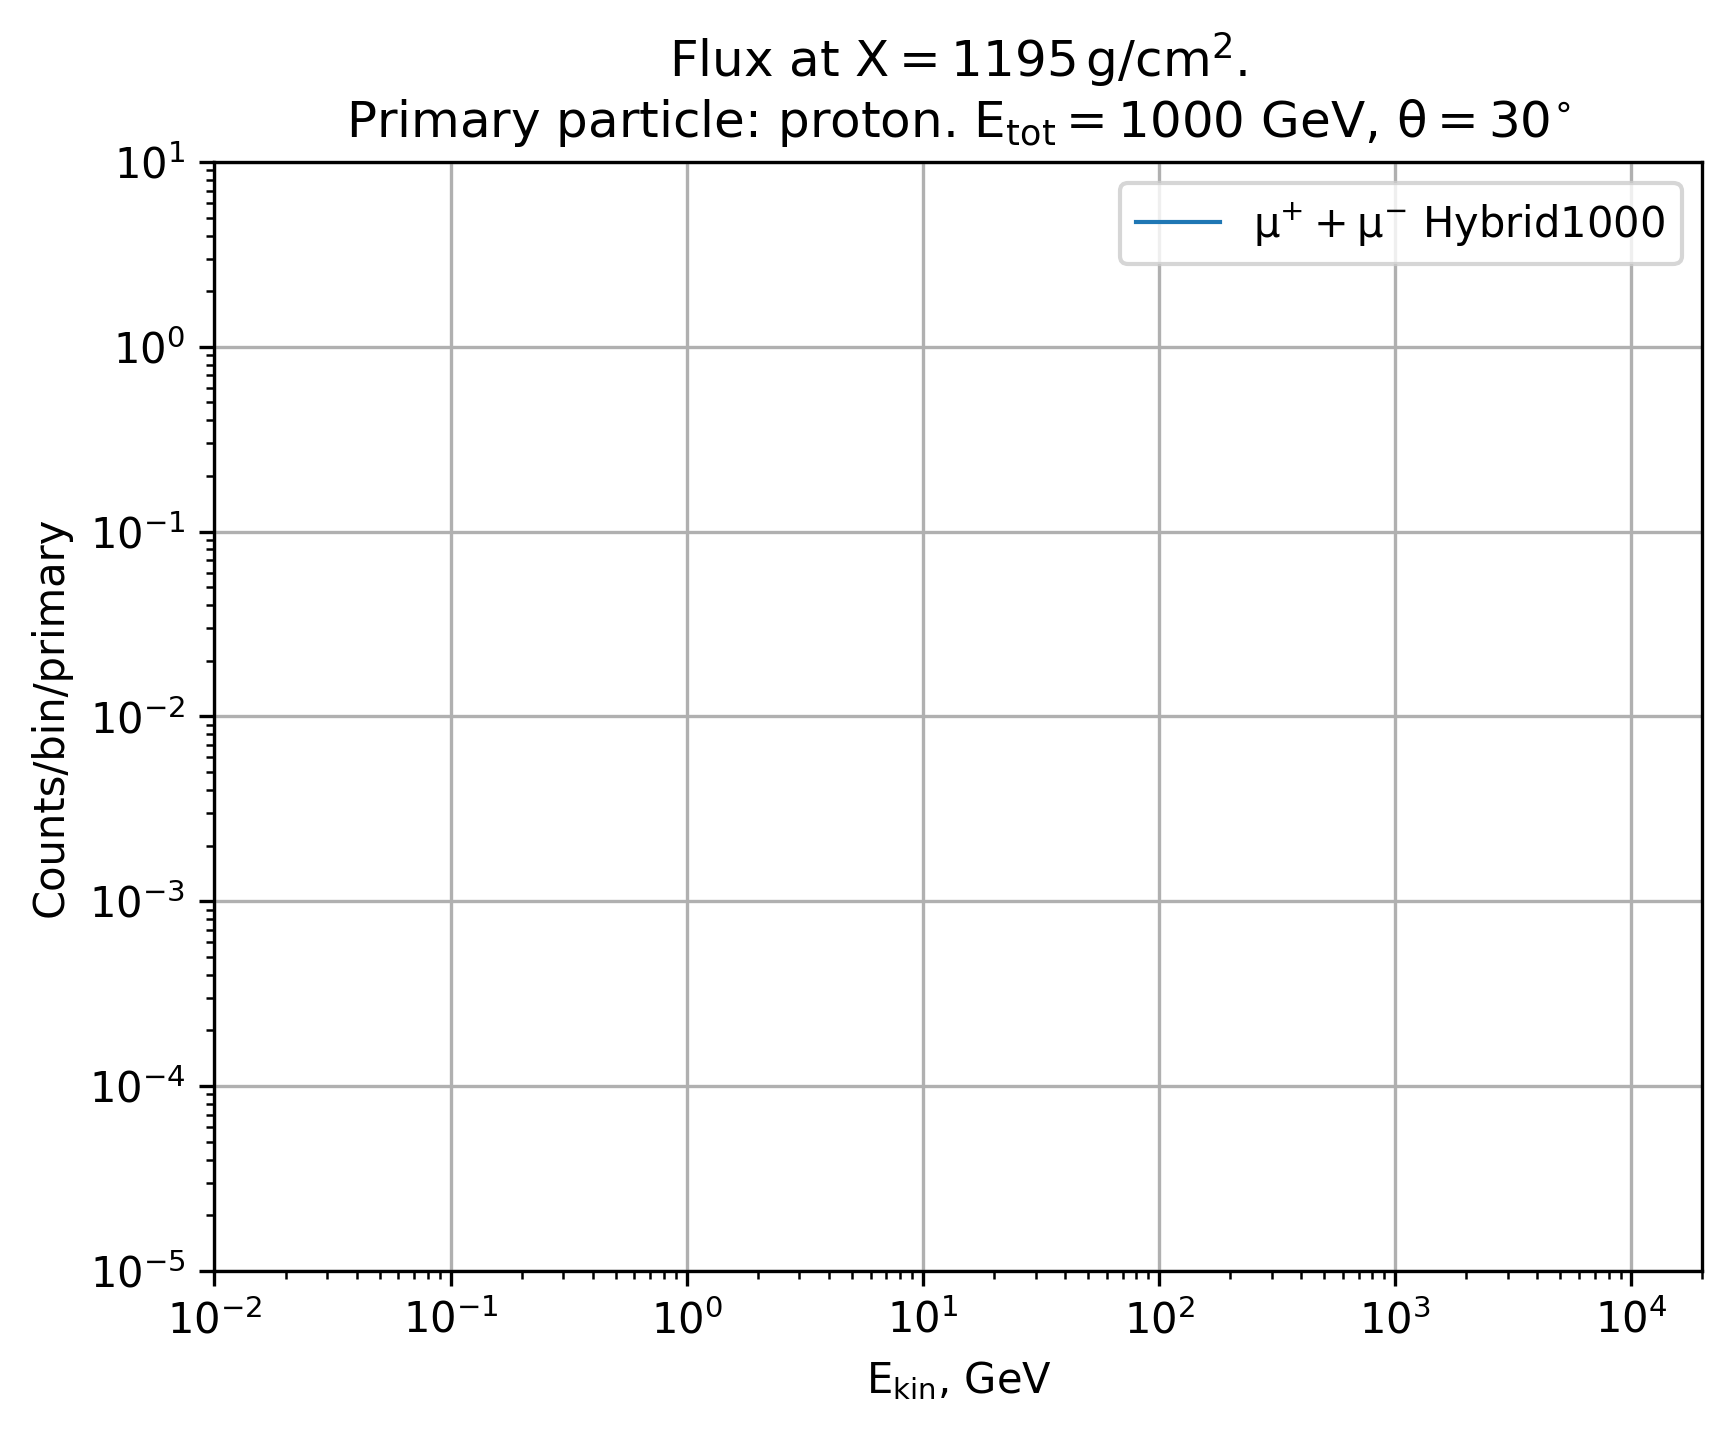

In [59]:
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ixdepth = 3
plt.stairs(mceq_dist.flux[ixdepth]["pi0"], mceq_dist.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ Hybrid" + f"{mceq_dist.slant_depths[ixdepth]}", 
           linestyle='-',
           color = line_colors[0])

# plt.stairs(mceq_loss.flux[ixdepth]["mu"], mceq_loss.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"{mceq_loss.slant_depths[ixdepth]}", 
#            linestyle='--',
#            color = line_colors[0])


# plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

# plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
# plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
#            color = line_colors[2])
# plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
#            color = line_colors[1])
# # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
#            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
#            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
#            label = r"${e}^{+}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
#            label = r"${e}^{-}$ mceq", linestyle='--')

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-2, 2e4)
plt.ylim(1e-5, 10)
plt.legend()
plt.grid()
plt.title("Flux at " +  r"$X = 1195\, g/cm^2.$"+ "\nPrimary particle: proton. " 
          +  r"$E_{tot}=1000$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Counts/bin/primary")

Text(0, 0.5, 'Counts/bin/primary')

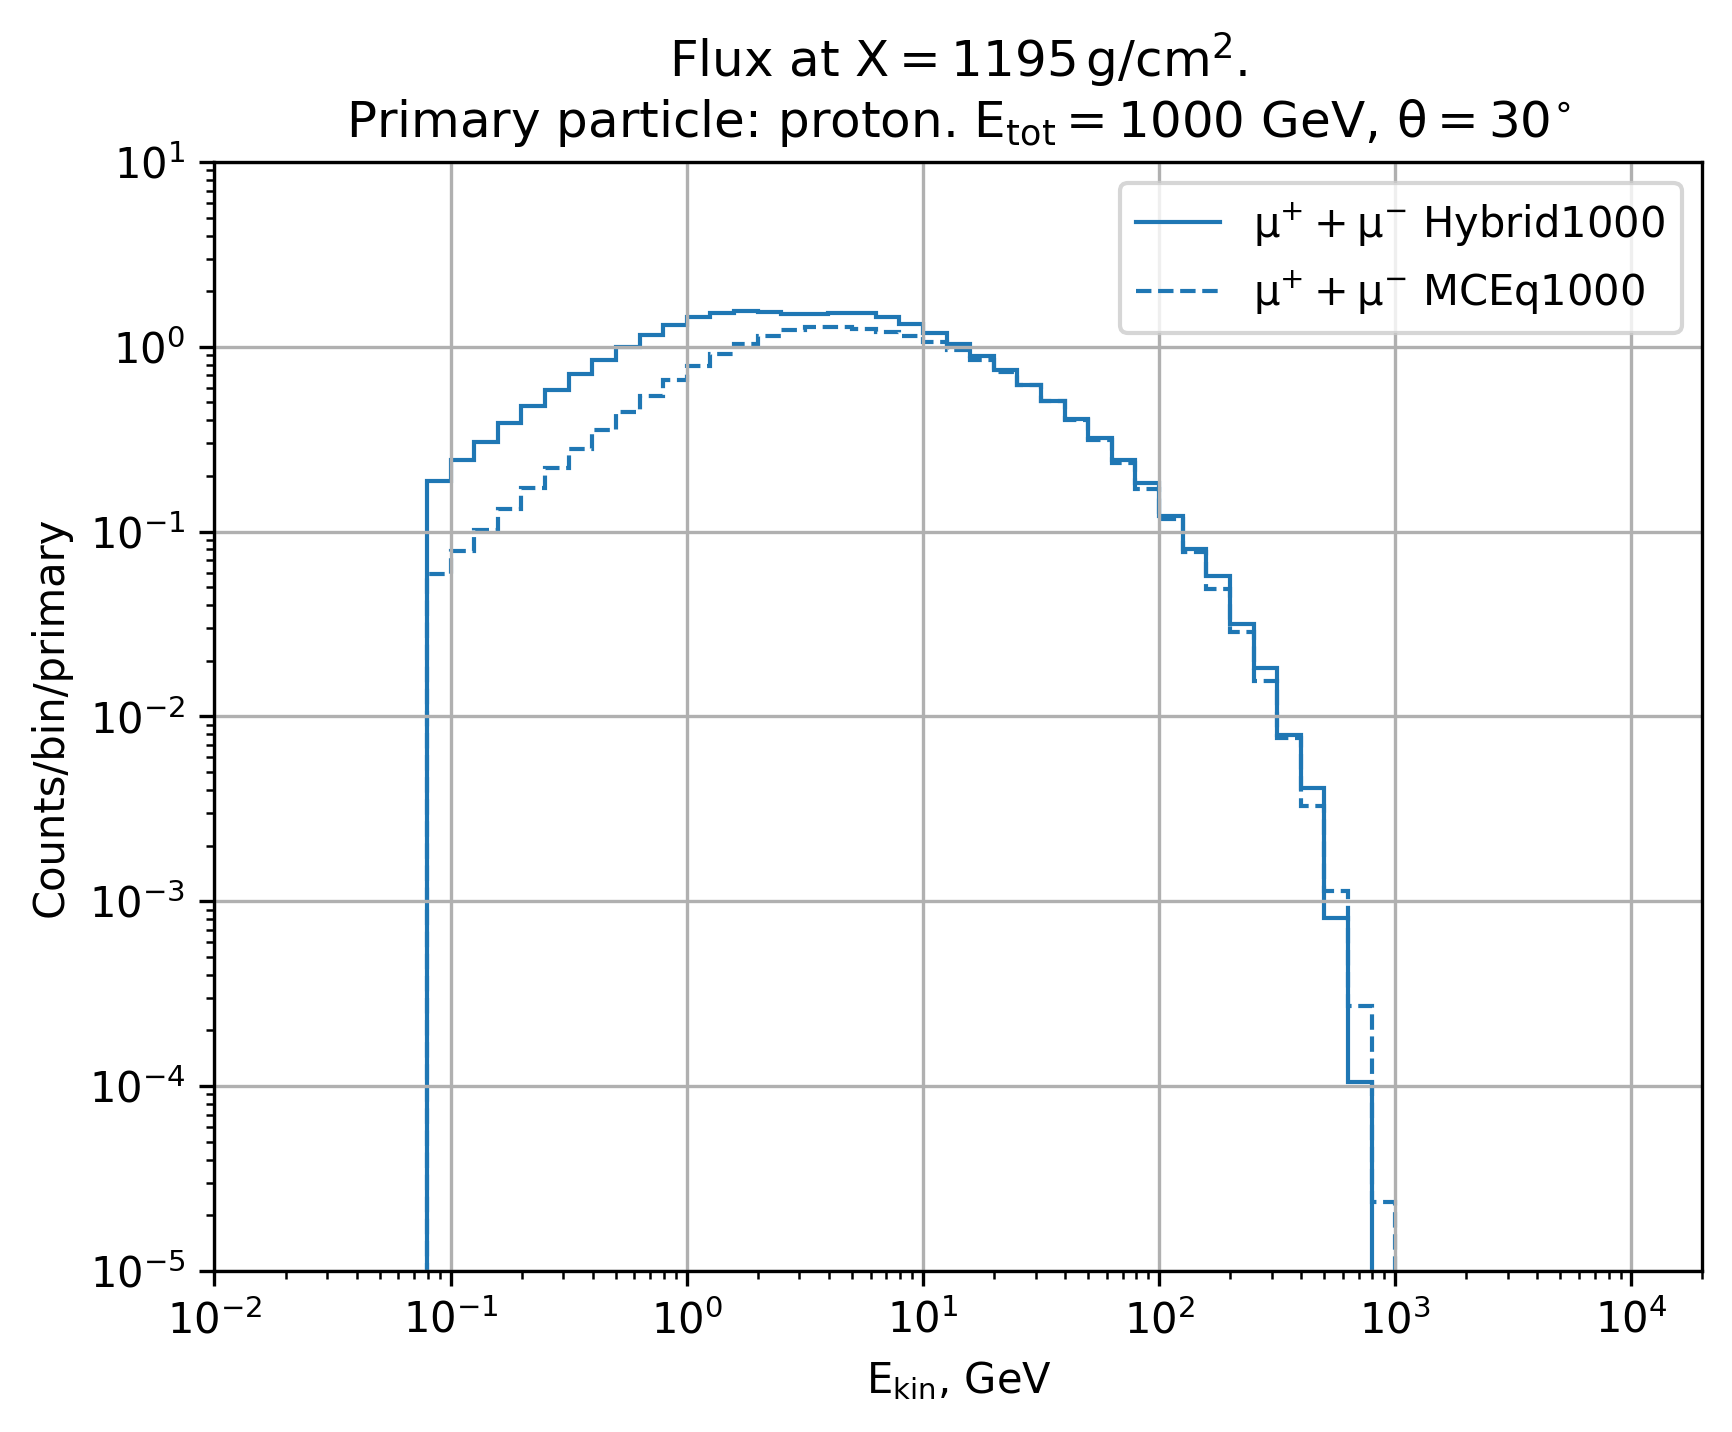

In [67]:
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-13, 13), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[0])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-12, -12), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[1])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-14, 14), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[2])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-211, 211), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-11, 11), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-11,), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (11,), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

ixdepth = 3
plt.stairs(mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ Hybrid" + f"{mceq_dist.slant_depths[ixdepth]}", 
           linestyle='-',
           color = line_colors[0])

plt.stairs(mceq_loss.flux[ixdepth]["mu"], mceq_loss.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"{mceq_loss.slant_depths[ixdepth]}", 
           linestyle='--',
           color = line_colors[0])


# plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

# plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
# plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
#            color = line_colors[2])
# plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
#            color = line_colors[1])
# # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
#            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
#            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
#            label = r"${e}^{+}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
#            label = r"${e}^{-}$ mceq", linestyle='--')

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-2, 2e4)
plt.ylim(1e-5, 10)
plt.legend()
plt.grid()
plt.title("Flux at " +  r"$X = 1195\, g/cm^2.$"+ "\nPrimary particle: proton. " 
          +  r"$E_{tot}=1000$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Counts/bin/primary")
# plt.savefig('01_nomuon_decay_flux.svg')

Text(0, 0.5, 'Counts/bin/primary')

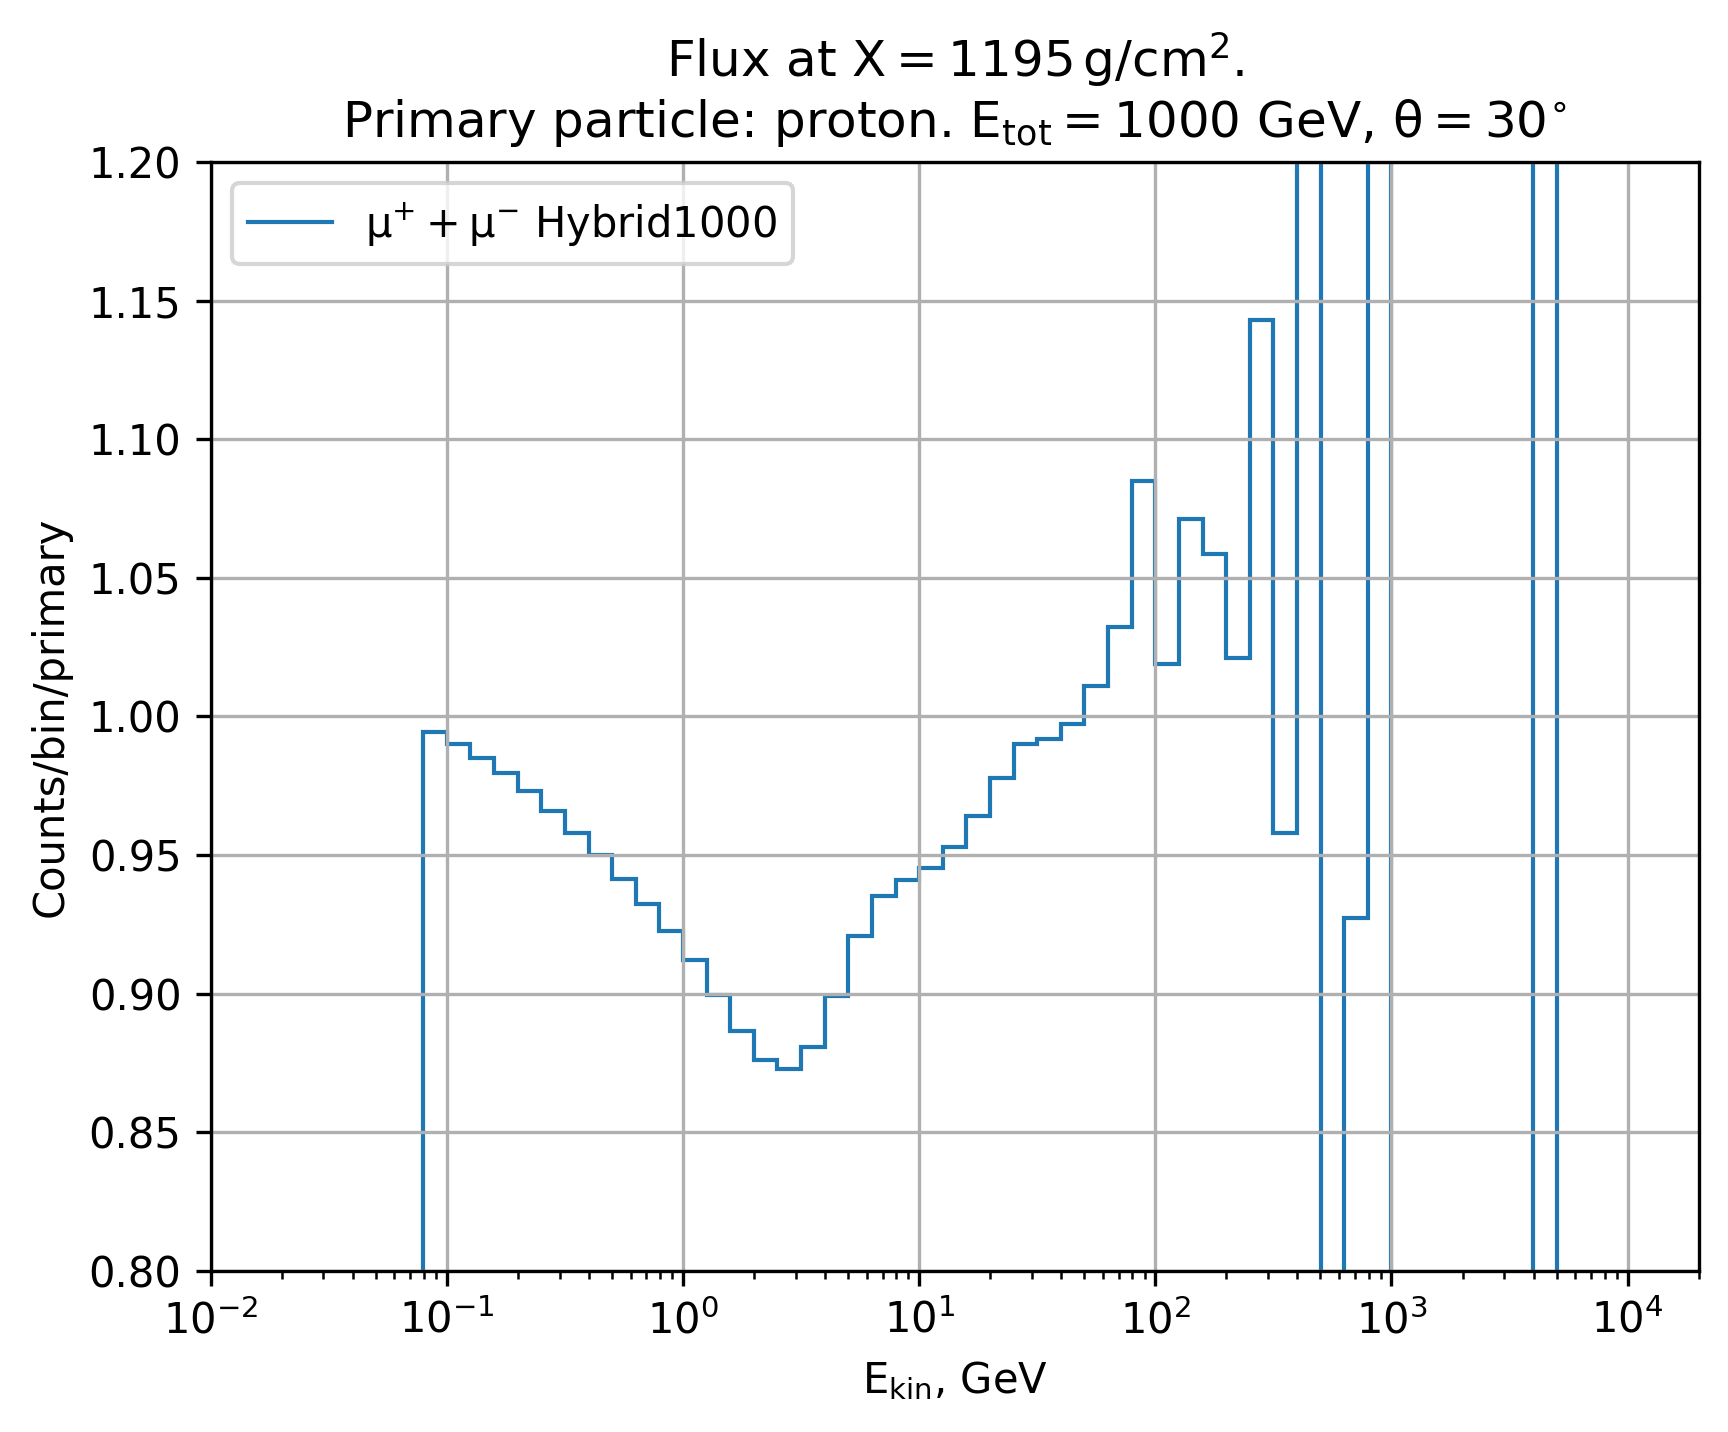

In [48]:
ixdepth = 3
plt.stairs(mceq_dist.flux[ixdepth]["mu"]/mceq_loss.flux[ixdepth]["mu"], mceq_dist.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ Hybrid" + f"{mceq_dist.slant_depths[ixdepth]}", 
           linestyle='-',
           color = line_colors[0])

# plt.stairs(mceq_loss.flux[ixdepth]["mu"], mceq_loss.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"{mceq_loss.slant_depths[ixdepth]}", 
#            linestyle='--',
#            color = line_colors[0])


# plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

# plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
# plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
#            color = line_colors[2])
# plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
#            color = line_colors[1])
# # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
#            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
#            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
#            label = r"${e}^{+}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
#            label = r"${e}^{-}$ mceq", linestyle='--')

plt.xscale("log")
# plt.yscale("log")
plt.xlim(1e-2, 2e4)
plt.ylim(0.8, 1.2)
plt.legend()
plt.grid()
plt.title("Flux at " +  r"$X = 1195\, g/cm^2.$"+ "\nPrimary particle: proton. " 
          +  r"$E_{tot}=1000$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Counts/bin/primary")

In [155]:
# Plot parameters
params = {"mathtext.default": "regular",
          "text.usetex": False,
          "figure.dpi": 300}          
plt.rcParams.update(params)

{22: 13336, 2212: 6004, -13: 5775, 14: 5775, 13: 5514, -14: 5514, 11: 2664, -12: 2588, 2112: 951, -11: 164, 12: 88, 111: 73, -2212: 65, 211: 60, -211: 60, 3122: 9, -2112: 2, -3122: 2}


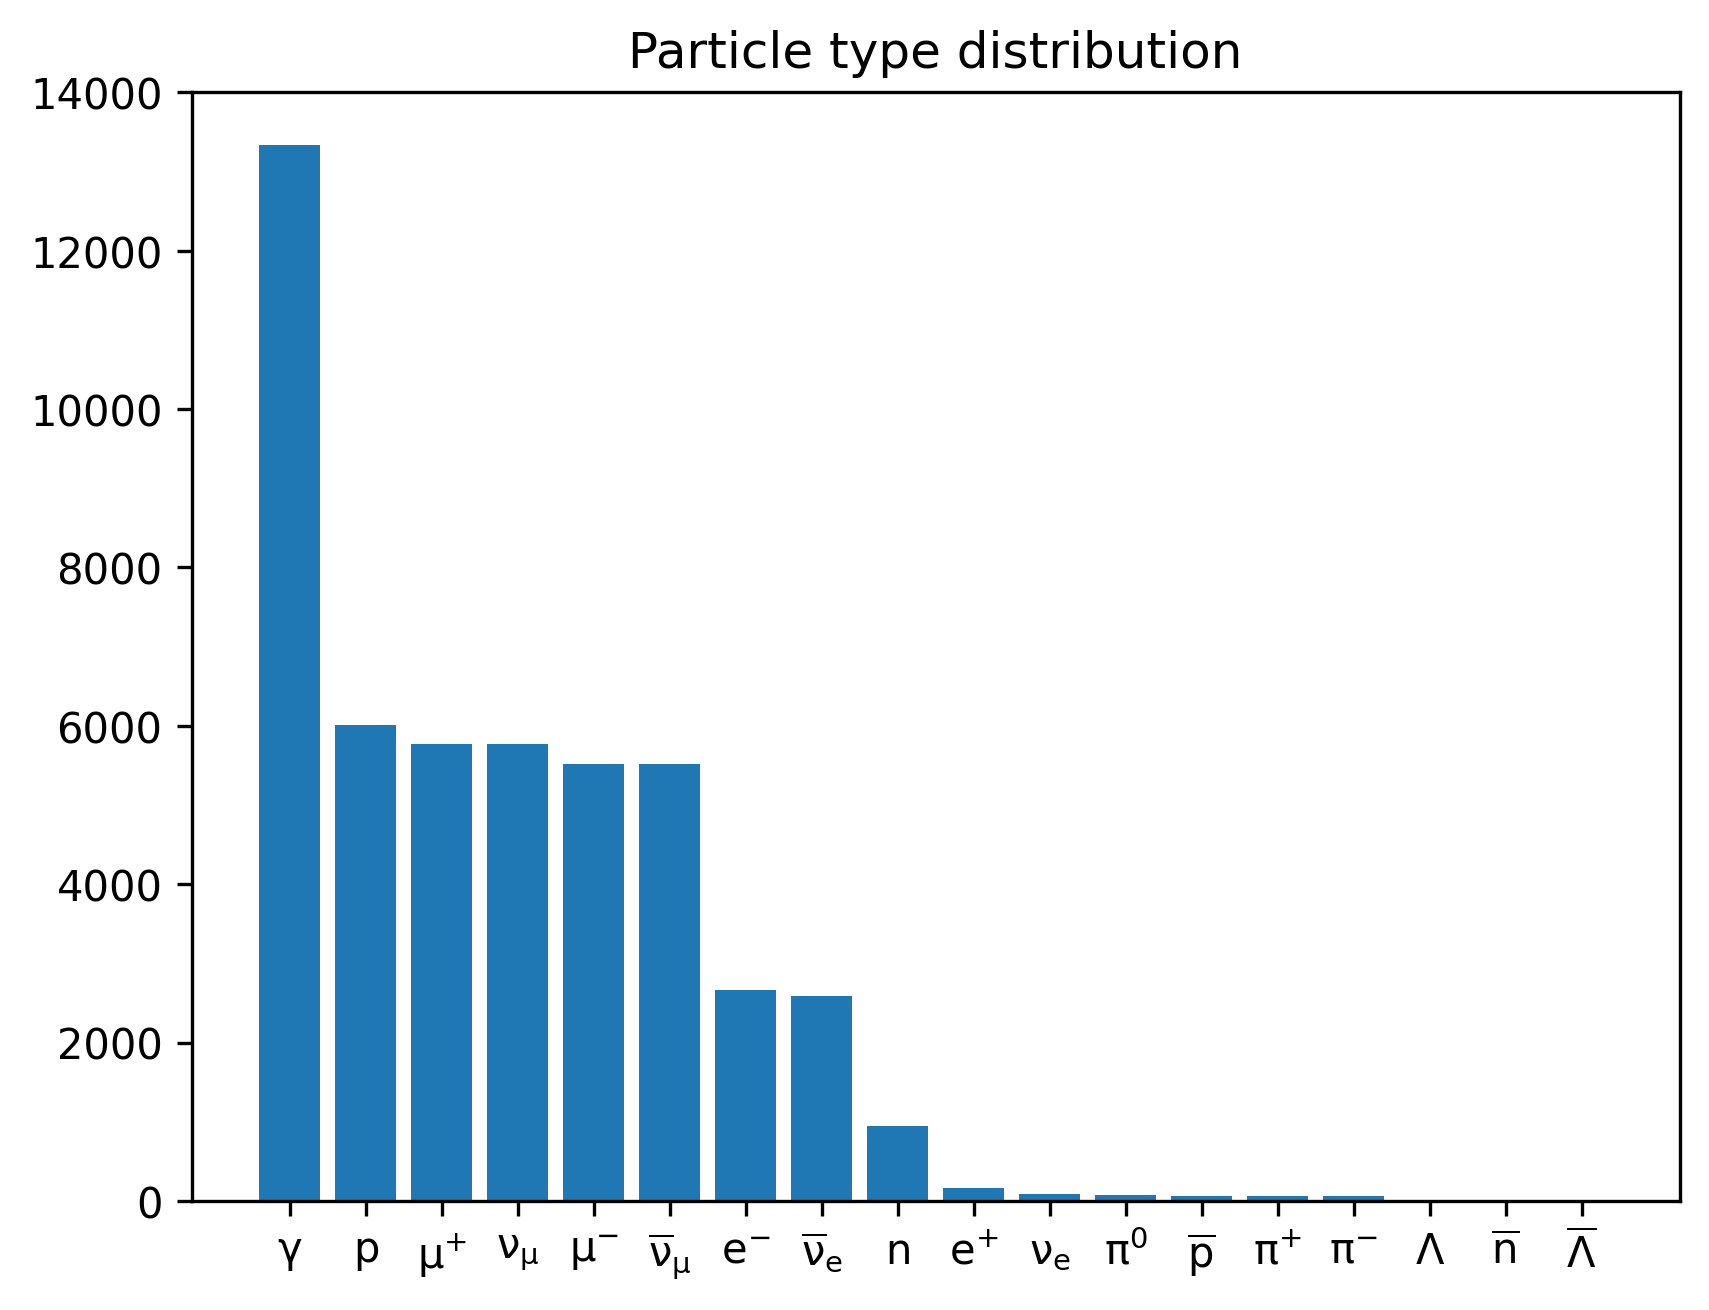

In [233]:
cascade_analysis.plot_ptypes_dist(from_ = 0)

In [ ]:
final_particles = cas_driver.get_final_particles().valid()

In [120]:
from mceq_comparison import MCEQDistributions

In [94]:
mceq_loss = MCEQDistributions(
                 energy = 1e2,
                 pdg_id = 2212,
                 theta_deg = 30,
                 energy_range=[3e-2, 2e2],
                 slant_depths=[66, 143, 638, 1193],
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-")
                     ],
                 interaction_model = "DPMJET-III-19.1",
                #  interaction_model = "SIBYLL23D",
                 generic_losses_all_charged = True, 
                 enable_energy_loss = True, 
                 muon_helicity_dependence = True,
                 disable_decays = [],
                 hybrid_crossover=0.01,
                 density_model = ("CORSIKA", ("USStd", None)))

MCEqRun::set_interaction_model(): DPMJETIII191
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


/hetghome/antonpr/MCEq/MCEq/solvers.py:40: RuntimeWarning: overflow encountered in multiply
  phc += (imc.dot(phc) + dmc.dot(ric[step] * phc)) * dxc[step]
/hetghome/antonpr/MCEq/MCEq/solvers.py:40: RuntimeWarning: invalid value encountered in add
  phc += (imc.dot(phc) + dmc.dot(ric[step] * phc)) * dxc[step]


In [258]:
mceq_loss1 = MCEQDistributions(
                 energy = 1e2,
                 pdg_id = 2212,
                 theta_deg = 30,
                 energy_range=[5e-2, 2e2],
                 slant_depths=[66, 143, 638, 1193],
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-")
                     ],
                 interaction_model = "DPMJET-III-19.1",
                #  interaction_model = "SIBYLL23D",
                 generic_losses_all_charged = True, 
                 enable_energy_loss = True, 
                 muon_helicity_dependence = True,
                 disable_decays = [],
                 hybrid_crossover=0.01,
                 density_model = ("CORSIKA", ("USStd", None)))

MCEqRun::set_interaction_model(): DPMJETIII191
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


In [259]:
mceq_noloss = MCEQDistributions(
                 energy = 1e2,
                 pdg_id = 2212,
                 theta_deg = 30,
                 energy_range=[1e-2, 2e2],
                 slant_depths=[66, 143, 638, 1195],
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-"),
                     ("pi_mu", "pi_mu+", "pi_mu-"),
                     ("k_mu",  "k_mu+", "k_mu-"),
                     ("K0_mu", "K0_mu+", "K0_mu-"),
                     ("prcas_mu", "prcas_mu+", "prcas_mu-"),
                     ("prres_mu", "prres_mu+", "prres_mu-"),
                     ],
                 interaction_model = "DPMJET-III-19.1",
                 generic_losses_all_charged = False, 
                 enable_energy_loss = False, 
                 muon_helicity_dependence = False,
                 disable_decays = [-13, 13, -211, 211],
                 hybrid_crossover=0.01,
                 density_model = ("CORSIKA", ("USStd", None)))
                #  disable_decays = [-13, 13, -211, 211, 111]
mceq_dist = mceq_noloss

MCEqRun::set_interaction_model(): DPMJETIII191


ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


Histogram of -211 with mass 0.13957039000000002
Histogram of 211 with mass 0.13957039000000002
Histogram of -211 with mass 0.13957039000000002
Histogram of 211 with mass 0.13957039000000002


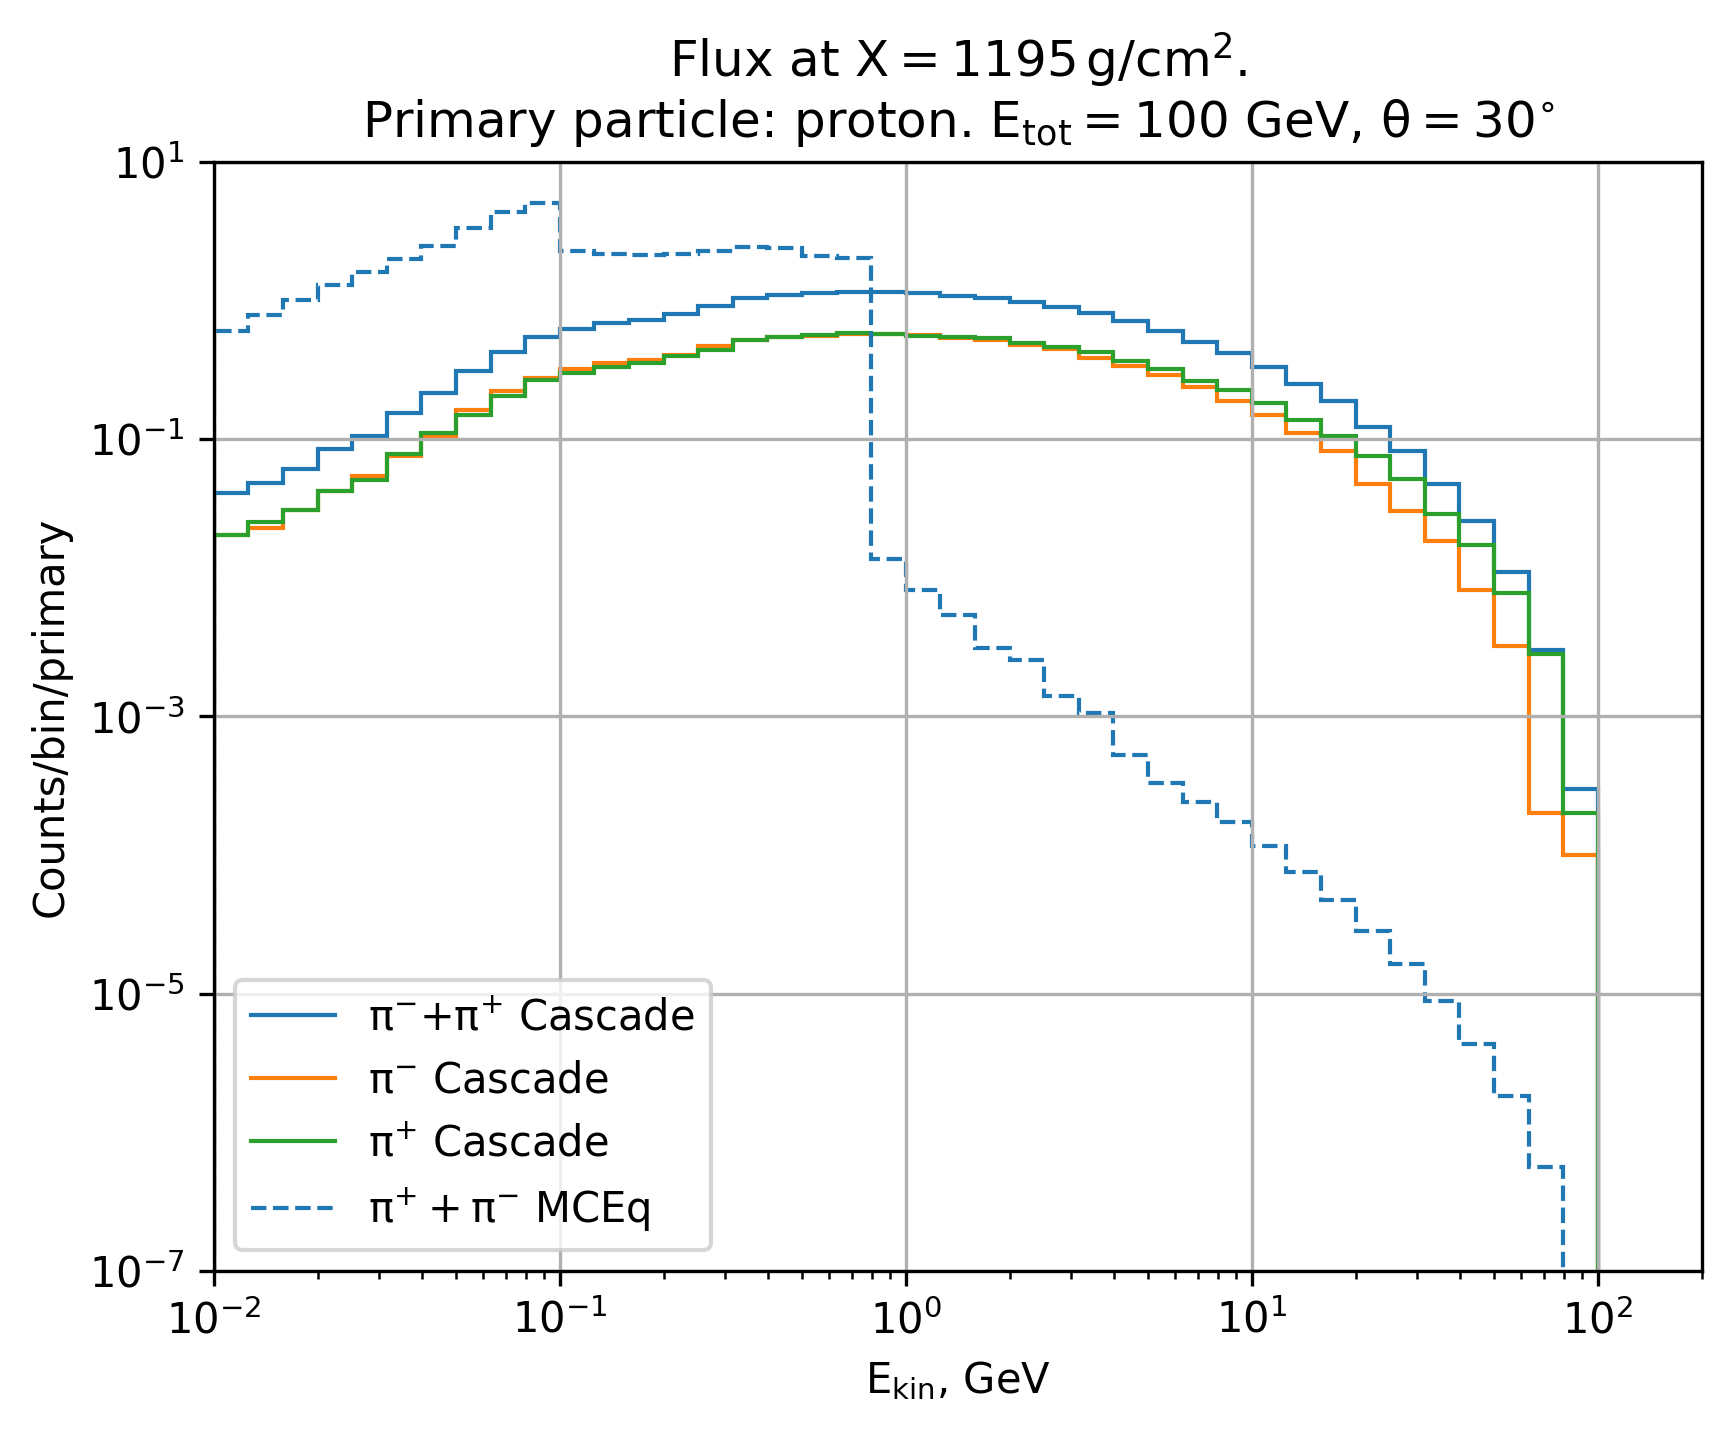

In [265]:
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-211, 211), bins = mceq_dist.e_bins)
plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[0])

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-211,), bins = mceq_dist.e_bins)
plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[1])

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (211,), bins = mceq_dist.e_bins)
plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[2])


ixdepth = 3
plt.stairs(mceq_dist.flux[ixdepth]["pi"], mceq_dist.e_bins, 
           label = r"${\pi}^{+} + {\pi}^{-}$ MCEq", linestyle='--',
           color = line_colors[0])

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-2, 2e2)
plt.ylim(1e-7, 10)
plt.legend()
plt.grid()
plt.title("Flux at " +  r"$X = 1195\, g/cm^2.$"+ "\nPrimary particle: proton. " 
          +  r"$E_{tot}=100$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Counts/bin/primary")
plt.savefig('04_nomuon_decay_piflux.svg')

Histogram of -13 with mass 0.10565837550000001
Histogram of 13 with mass 0.10565837550000001


Text(0, 0.5, 'Counts/bin/primary')

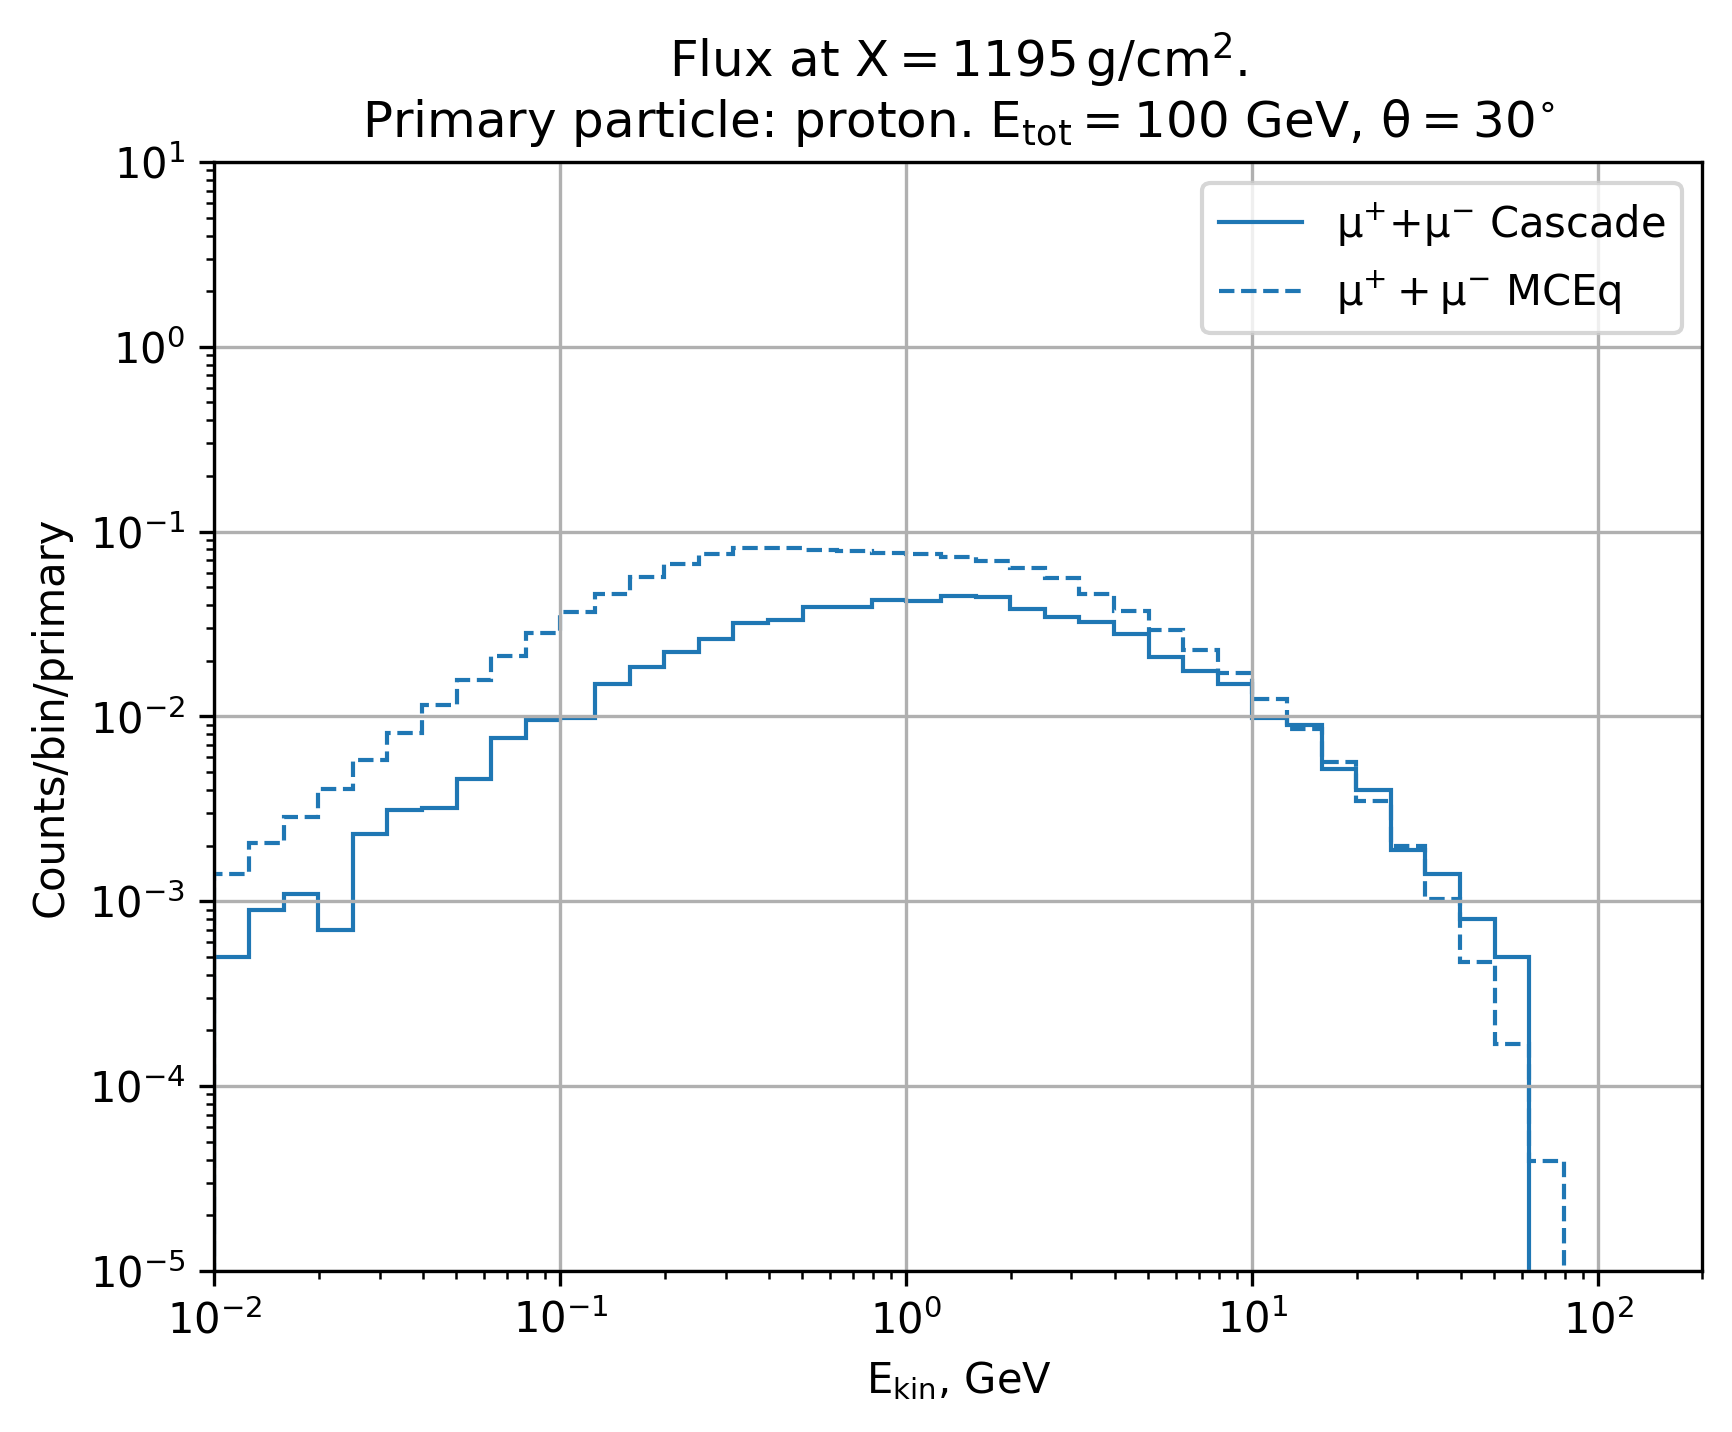

In [263]:
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-13, 13), bins = mceq_dist.e_bins)
plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[0])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-12, -12), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[1])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-14, 14), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[2])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-211, 211), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-11, 11), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-11,), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (11,), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

ixdepth = 3
plt.stairs(mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ MCEq", linestyle='--',
           color = line_colors[0])


# plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

# plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
# plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
#            color = line_colors[2])
# plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
#            color = line_colors[1])
# # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
#            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
#            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
#            label = r"${e}^{+}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
#            label = r"${e}^{-}$ mceq", linestyle='--')

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-2, 2e2)
plt.ylim(1e-5, 10)
plt.legend()
plt.grid()
plt.title("Flux at " +  r"$X = 1195\, g/cm^2.$"+ "\nPrimary particle: proton. " 
          +  r"$E_{tot}=100$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Counts/bin/primary")
# plt.savefig('01_nomuon_decay_flux.svg')

Histogram of -13 with mass 0.10565837550000001
Histogram of 13 with mass 0.10565837550000001
Histogram of -12 with mass 0.0
Histogram of 12 with mass 0.0
Histogram of -14 with mass 0.0
Histogram of 14 with mass 0.0


/tmp/ipykernel_2052987/1296374379.py:4: RuntimeWarning: invalid value encountered in divide
  plt.stairs(hist/mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins,
/tmp/ipykernel_2052987/1296374379.py:9: RuntimeWarning: invalid value encountered in divide
  plt.stairs(hist/mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins,
/tmp/ipykernel_2052987/1296374379.py:14: RuntimeWarning: invalid value encountered in divide
  plt.stairs(hist/mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins,


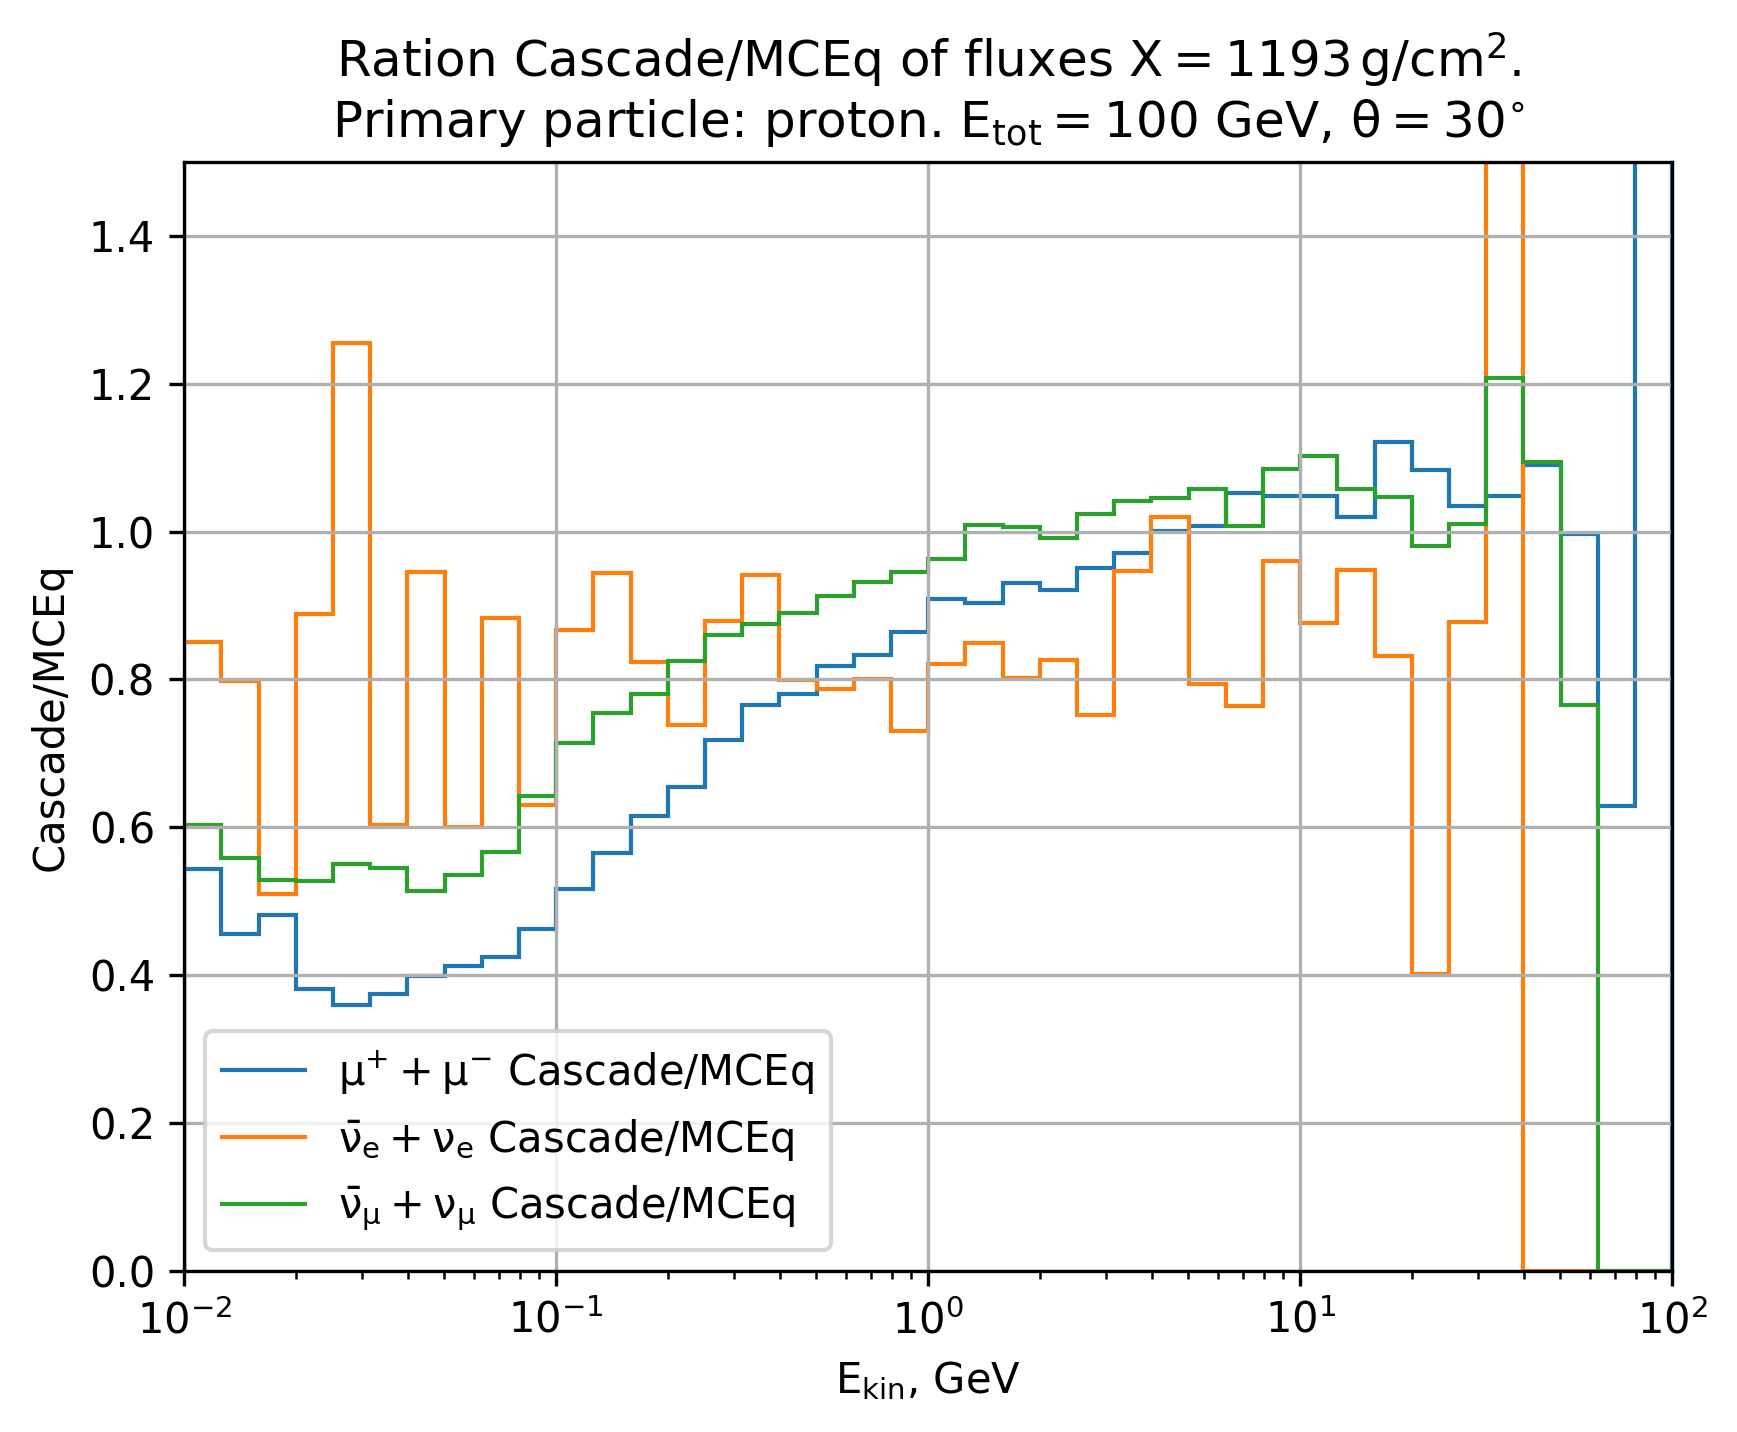

In [241]:
bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-13, 13), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')
ixdepth = 3
plt.stairs(hist/mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ Cascade/MCEq", linestyle='-')

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-12, 12), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')
plt.stairs(hist/mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
           label = r"$\bar{\nu}_{e} + {\nu}_{e}$ Cascade/MCEq", linestyle='-')

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-14, 14), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')
plt.stairs(hist/mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
           label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ Cascade/MCEq", linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-11, 11), bins = mceq_dist.e_bins)
# # plt.stairs(hist, bins, label = label, linestyle='-')
# plt.stairs(hist/mceq_dist.flux["el"], mceq_dist.e_bins, 
#            label = r"${e}^{+} + {e}^{-}$ mceq no loss", linestyle='-')

# plt.stairs(mceq_loss.flux["mu"], mceq_loss.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ mceq loss", linestyle='--')

plt.xscale("log")
plt.xlim(1e-2, 1e2)
plt.ylim(0, 1.5)
plt.legend()
plt.grid()
plt.title("Ration Cascade/MCEq of fluxes " +  r"$X = 1193\, g/cm^2.$"+
          "\nPrimary particle: proton. " 
          +  r"$E_{tot}=100$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Cascade/MCEq")
plt.savefig('01_nomuon_decay_ratio.svg')

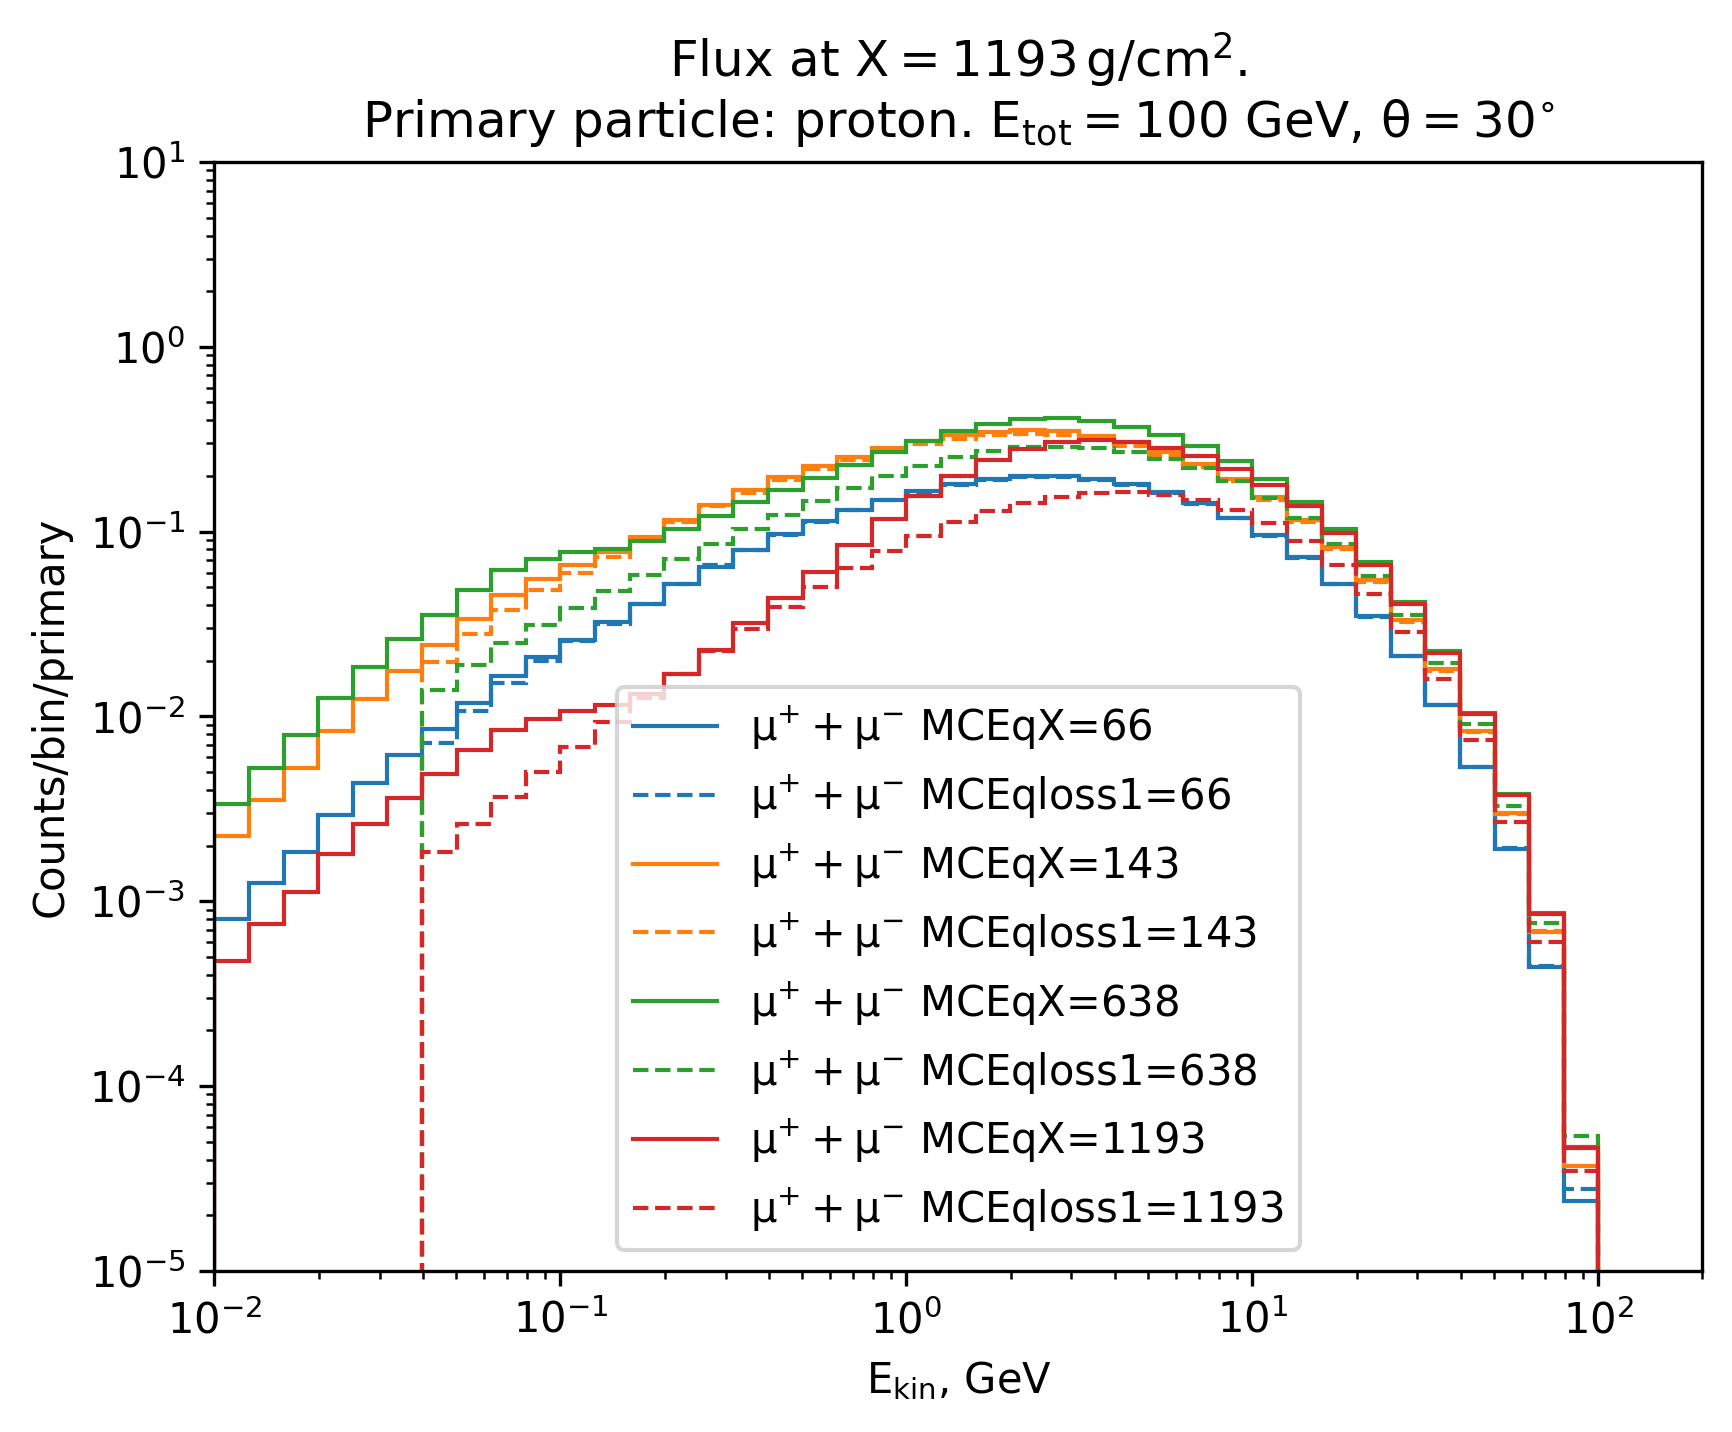

In [158]:
ixdepth = 0
xdepths_list = [0, 1, 2, 3]
# xdepths_list = [2, 3]

for ixdepth in xdepths_list:
    plt.stairs(mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
            label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"X={mceq_dist.slant_depths[ixdepth]}", linestyle='-',
            color = line_colors[ixdepth])
    
#     plt.stairs(mceq_loss.flux[ixdepth]["mu"], mceq_loss.e_bins, 
#             label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"X={mceq_loss.slant_depths[ixdepth]}", 
#             linestyle='--',
#             color = line_colors[ixdepth])
    
    plt.stairs(mceq_loss1.flux[ixdepth]["mu"], mceq_loss1.e_bins, 
            label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"loss1={mceq_loss1.slant_depths[ixdepth]}", 
            linestyle='--',
            color = line_colors[ixdepth])


    # plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
    #            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

    # plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
    #            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
    # plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
    #         label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
    #         color = line_colors[2])
    # plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
    #         label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
    #         color = line_colors[1])
    # # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
    #            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
    #            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
    #            label = r"${e}^{+}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
    #            label = r"${e}^{-}$ mceq", linestyle='--')

    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-2, 2e2)
    plt.ylim(1e-5, 10)
    plt.legend()
    plt.grid()
    plt.title("Flux at " +  r"$X = 1193\, g/cm^2.$"+ "\nPrimary particle: proton. " 
            +  r"$E_{tot}=100$ GeV" + r", $\theta = 30^{\circ}$")
    plt.xlabel(r"$E_{kin}$, GeV")
    plt.ylabel(r"Counts/bin/primary")
# plt.savefig('temp.png', transparent=True)

In [224]:
mceq_noloss = MCEQDistributions(
                 energy = 1e2,
                 pdg_id = 2212,
                 theta_deg = 30,
                 energy_range=[1e-2, 2e2],
                 slant_depths=[66, 143, 638, 1195],
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-"),
                     ("pi_mu", "pi_mu+", "pi_mu-"),
                     ("k_mu",  "k_mu+", "k_mu-"),
                     ("K0_mu", "K0_mu+", "K0_mu-"),
                     ("prcas_mu", "prcas_mu+", "prcas_mu-"),
                     ("prres_mu", "prres_mu+", "prres_mu-"),
                     ],
                 interaction_model = "DPMJET-III-19.1",
                 generic_losses_all_charged = False, 
                 enable_energy_loss = False, 
                 muon_helicity_dependence = False,
                 disable_decays = [],
                 hybrid_crossover=0.01,
                 density_model = ("CORSIKA", ("USStd", None)))
                #  disable_decays = [-13, 13, -211, 211, 111]
mceq_dist = mceq_noloss

MCEqRun::set_interaction_model(): DPMJETIII191


ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


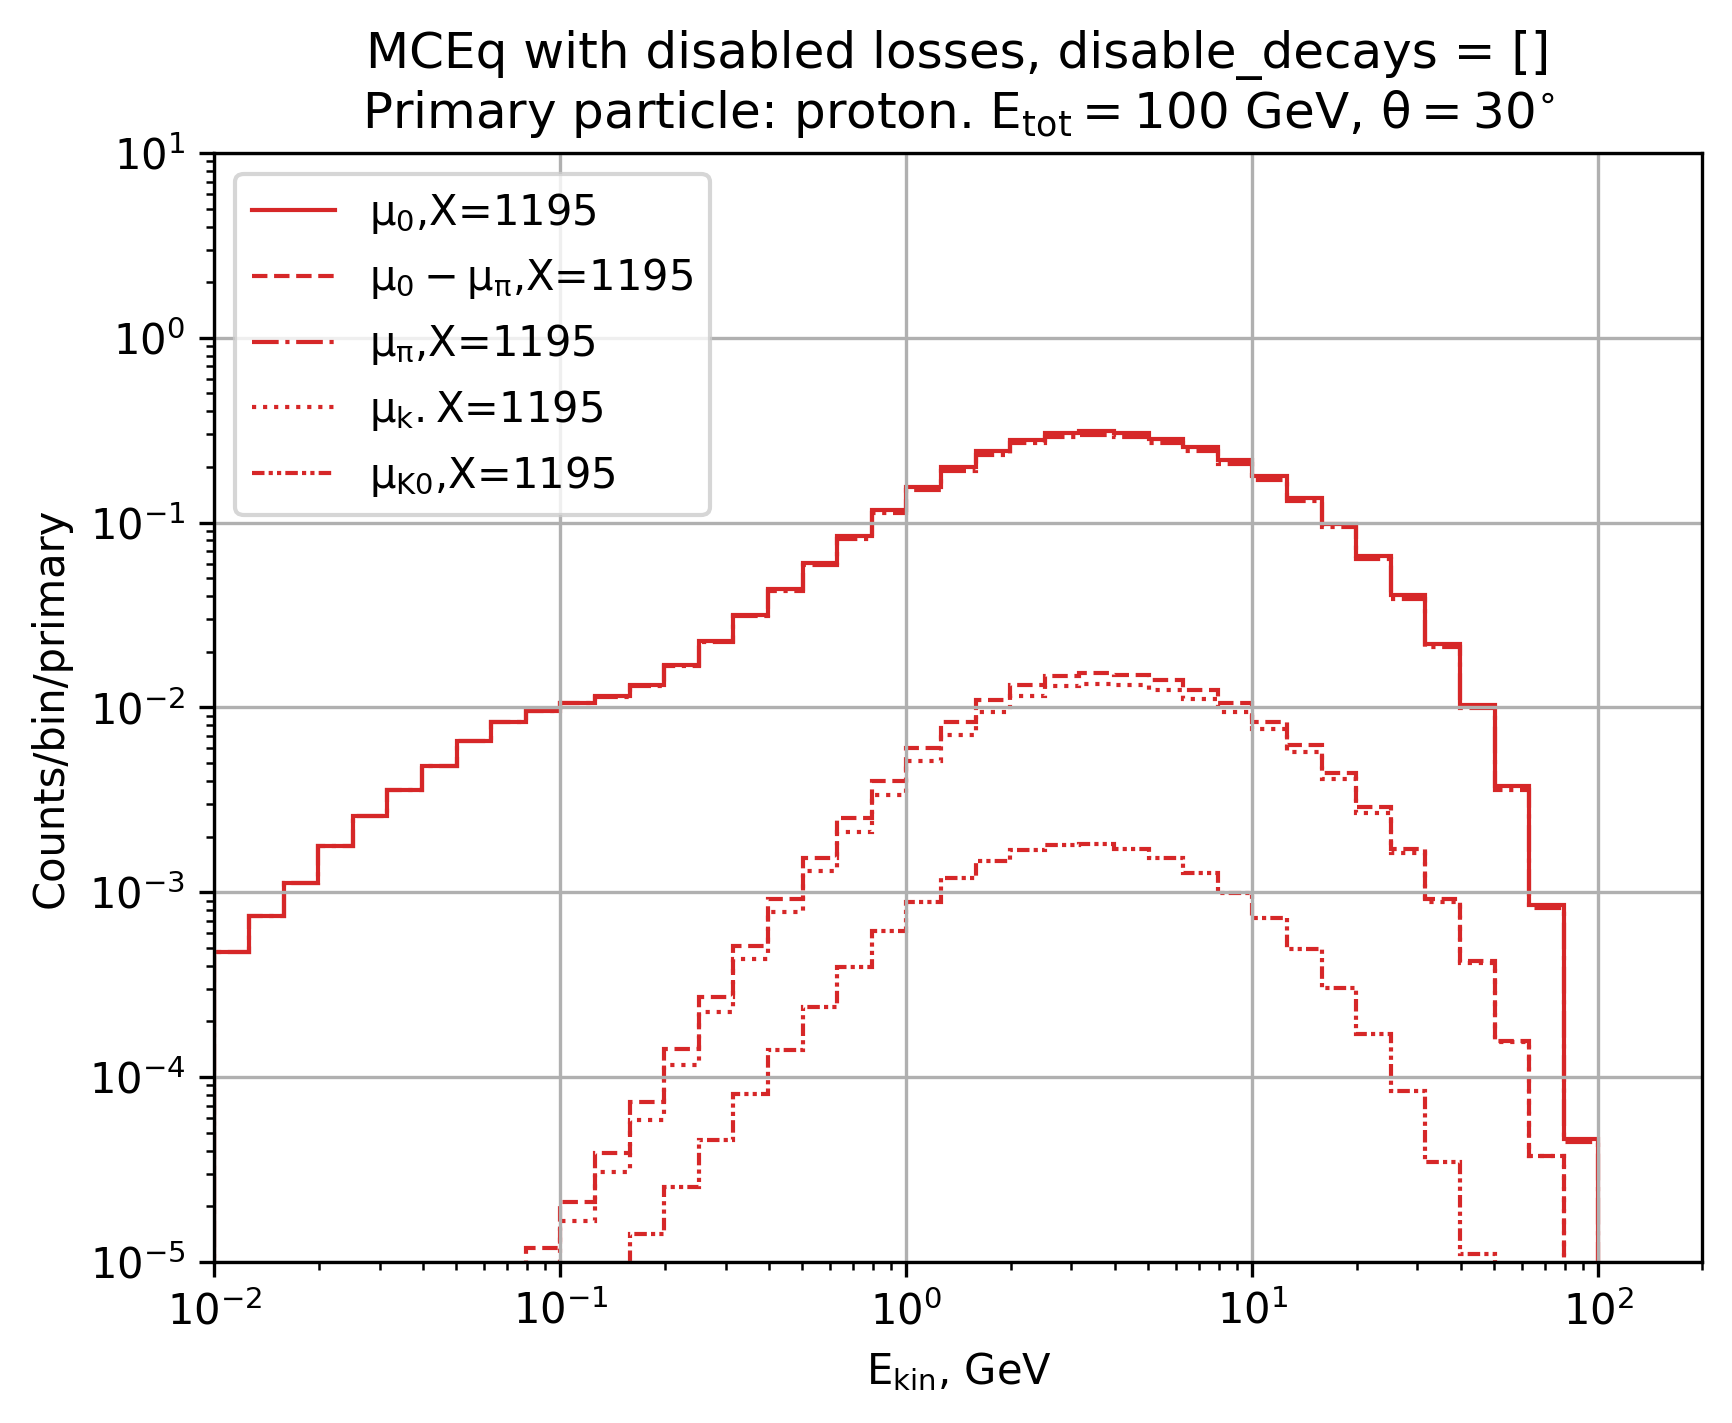

In [225]:
# xdepths_list = [0, 1, 2, 3]
xdepths_list = [3]

for ixdepth in xdepths_list:
    plt.stairs(mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
            label = r"$\mu_0$," 
            + f"X={mceq_dist.slant_depths[ixdepth]}", 
            linestyle='-',
            color = line_colors[ixdepth])    
        
        
    plt.stairs(mceq_dist.flux[ixdepth]["mu"] - mceq_dist.flux[ixdepth]["pi_mu"], mceq_dist.e_bins, 
            label = r"$\mu_0 - \mu_{\pi}$," 
            + f"X={mceq_dist.slant_depths[ixdepth]}", 
            linestyle='--',
            color = line_colors[ixdepth])
    
    plt.stairs(mceq_dist.flux[ixdepth]["pi_mu"], mceq_dist.e_bins, 
            label = r"$\mu_{\pi}$," 
            + f"X={mceq_dist.slant_depths[ixdepth]}", 
            linestyle='-.',
            color = line_colors[ixdepth])
    
    plt.stairs(mceq_dist.flux[ixdepth]["k_mu"], mceq_dist.e_bins, 
            label = r"$\mu_{k}.$" 
            + f"X={mceq_dist.slant_depths[ixdepth]}", 
            linestyle=':',
            color = line_colors[ixdepth])
    
    plt.stairs(mceq_dist.flux[ixdepth]["K0_mu"], mceq_dist.e_bins, 
            label = r"$\mu_{K0}$," 
            + f"X={mceq_dist.slant_depths[ixdepth]}", 
            linestyle=(0, (3, 1, 1, 1, 1, 1)),
            color = line_colors[ixdepth])
    
#     plt.stairs(mceq_loss.flux[ixdepth]["mu"], mceq_loss.e_bins, 
#             label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"X={mceq_loss.slant_depths[ixdepth]}", 
#             linestyle='--',
#             color = line_colors[ixdepth])
    
    # plt.stairs(mceq_loss1.flux[ixdepth]["mu"], mceq_loss1.e_bins, 
    #         label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"loss1={mceq_loss1.slant_depths[ixdepth]}", 
    #         linestyle='--',
    #         color = line_colors[ixdepth])


    # plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
    #            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

    # plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
    #            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
    # plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
    #         label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
    #         color = line_colors[2])
    # plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
    #         label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
    #         color = line_colors[1])
    # # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
    #            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
    #            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
    #            label = r"${e}^{+}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
    #            label = r"${e}^{-}$ mceq", linestyle='--')

    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-2, 2e2)
    plt.ylim(1e-5, 10)
    plt.legend()
    plt.grid()
    plt.title("MCEq with disabled losses, disable_decays = []" + "\nPrimary particle: proton. " 
            +  r"$E_{tot}=100$ GeV" + r", $\theta = 30^{\circ}$")
    plt.xlabel(r"$E_{kin}$, GeV")
    plt.ylabel(r"Counts/bin/primary")
plt.savefig('16_MCEq_noloss.svg')